# Unified LSTM + XGBoost Hybrid for Pharmacy Sales Forecasting

This notebook implements a hybrid model combining Long Short-Term Memory (LSTM) neural networks and XGBoost for forecasting daily sales of 8 drug categories (`M01AB`, `M01AE`, `N02BA`, `N02BE`, `N05B`, `N05C`, `R03`, `R06`) using `holidays.csv`. It supports 1-step-ahead, 7-day-ahead, and 30-day-ahead forecasts, evaluated with MAE, RMSE, and sMAPE metrics, and includes visualizations for interpretability.

## Model Description
The hybrid model leverages:
- **LSTM**: Captures temporal dependencies in sales data with a 7-day lookback.
  - **Key Formula**: Hidden state update: \( h_t = o_t \cdot \tanh(C_t) \)
  - **Advantages**:
    - Models sequential patterns effectively.
    - Handles multi-output forecasting for 8 drugs simultaneously.
- **XGBoost**: Corrects LSTM residuals for each drug series.
  - **Key Formula**: \( y_{\text{hybrid}} = y_{\text{LSTM}} + \sum_{k=1}^{600} w_k \cdot f_k(X_{\text{lag}, \text{exo}}) \)
  - **Advantages**:
    - Captures non-linear patterns missed by LSTM.
    - Improves accuracy with feature-rich inputs (lags, rolling stats, holidays).
- **Hybrid Benefits**:
  - Combines LSTM’s temporal modeling with XGBoost’s residual correction.
  - Flexible for multiple forecast horizons.
  - Robust to noisy pharmacy sales data.

## Installing Dependencies
Installs the specific version of XGBoost (2.1.1) required for the hybrid model. This ensures compatibility and consistent performance for residual correction.

## Importing Libraries
Imports essential libraries for data processing (`pandas`, `numpy`), visualization (`matplotlib`), preprocessing (`sklearn`), deep learning (`tensorflow`, `keras`), and gradient boosting (`xgboost`). Sets random seeds for reproducibility.

In [ ]:
!pip -q install xgboost==2.1.1 #Dependency

#Libraries
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from xgboost import XGBRegressor
np.random.seed(42)
tf.random.set_seed(42)

## Loading Data
Loads the `holidays.csv` dataset containing daily sales and exogenous features (e.g., holidays). Checks for file existence to ensure the dataset is available in the working directory.

In [ ]:
#Load data
csv_path = "/content/holidays.csv"
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Could not find '{csv_path}'. Upload it to the Colab working directory (/content).")
df_raw = pd.read_csv(csv_path)

## Data Cleaning and Date Handling
Identifies and formats the date column in the dataset, sorting by date for temporal consistency.

In [ ]:
#Basic cleaning & date handling
def find_date_col(df: pd.DataFrame) -> str:
    candidates = [c for c in df.columns if str(c).lower() in ["date", "ds", "timestamp", "day", "day_date"] or "date" in str(c).lower()]
    for c in candidates:
        try:
            pd.to_datetime(df[c])
            return c
        except Exception:
            pass
    c = df.columns[0]
    try:
        pd.to_datetime(df[c])
        return c
    except Exception:
        return None

date_col = find_date_col(df_raw)
df = df_raw.copy()
if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.sort_values(date_col).reset_index(drop=True)
else:
    df.insert(0, "synthetic_date", pd.date_range(start="2000-01-01", periods=len(df), freq="D"))
    date_col = "synthetic_date"

## Setting Target Columns
Defines the 8 drug categories (`M01AB`, `M01AE`, `N02BA`, `N02BE`, `N05B`, `N05C`, `R03`, `R06`) as targets. Resolves column names flexibly to handle variations (e.g., case sensitivity, underscores) and validates their presence.

In [ ]:
#Set target drug columns
requested_targets = ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']
present_cols = df.columns.tolist()
def resolve_column(name, cols):
    if name in cols:
        return name
    alt = name.replace("/", "_")
    if alt in cols:
        return alt
    lower_map = {c.lower(): c for c in cols}
    if name.lower() in lower_map:
        return lower_map[name.lower()]
    for c in cols:
        if c.lower().startswith(name.lower()):
            return c
    for c in cols:
        if name.lower() in c.lower():
            return c
    return None

target_cols = []
missing = []
for t in requested_targets:
    resolved = resolve_column(t, present_cols)
    if resolved is None:
        missing.append(t)
    else:
        target_cols.append(resolved)

if missing:
    raise ValueError(f"Target columns not found in '{csv_path}': {missing}. Resolved: {target_cols}")
if len(target_cols) != 8:
    raise ValueError(f"Resolved target columns count != 8. Resolved: {target_cols}")
print("Using target columns:", target_cols)

Using target columns: ['M01AB', 'M01AE', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03', 'R06']


## Building Exogenous Features
Extracts numerical features (excluding targets) and creates calendar-based features (day of week, day of month, month, week, weekend indicator). Handles missing values with forward and backward filling for robust input data.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Numerical Features  | Excludes target columns       |
| Calendar Features   | `dow`, `dom`, `month`, `week`, `is_weekend` |
| Missing Value Fill  | Forward fill, then backward fill |

In [ ]:
#Build exogenous feature set
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feat_cols = [c for c in num_cols if c not in target_cols]
cal = pd.DataFrame(index=df.index)
cal["dow"] = df[date_col].dt.weekday
cal["dom"] = df[date_col].dt.day
cal["month"] = df[date_col].dt.month
cal["week"] = df[date_col].dt.isocalendar().week.astype(int)
cal["is_weekend"] = (cal["dow"] >= 5).astype(int)
X_df = pd.concat([df[feat_cols].copy(), cal], axis=1)
X_df = X_df.loc[:, ~X_df.columns.duplicated()]
X_df = X_df.fillna(method="ffill").fillna(method="bfill")
Y_df = df[target_cols].copy().fillna(method="ffill").fillna(method="bfill")

/tmp/ipython-input-836848369.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="ffill").fillna(method="bfill")
/tmp/ipython-input-836848369.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Y_df = df[target_cols].copy().fillna(method="ffill").fillna(method="bfill")


## Train/Validation/Test Split
Splits the dataset into training (70%), validation (10%), and test (20%) sets, ensuring at least 14 validation and 28 test days for robust evaluation.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Test Size           | max(28, 20% of dataset)       |
| Validation Size     | max(14, 10% of dataset)       |
| Training Size       | Remaining (~70%)              |

In [ ]:
#Train/Val/Test split
test_size = max(28, int(0.2 * len(df)))
val_size = max(14, int(0.1 * len(df)))
train_end = len(df) - test_size - val_size
val_end = len(df) - test_size
X_train, X_val, X_test = X_df.iloc[:train_end], X_df.iloc[train_end:val_end], X_df.iloc[val_end:]
Y_train, Y_val, Y_test = Y_df.iloc[:train_end], Y_df.iloc[train_end:val_end], Y_df.iloc[val_end:]
dates_test = df[date_col].iloc[val_end:].reset_index(drop=True)

## Scaling Features and Targets
Standardizes features (`X_df`) and targets (`Y_df`) using `StandardScaler` to normalize data for LSTM training, preserving scale for predictions.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Scaler              | `StandardScaler`              |
| Applied to          | Features (`X_train`, `X_val`, `X_test`) and Targets (`Y_train`, `Y_val`, `Y_test`) |

In [ ]:
#Scaling
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_train_s = X_scaler.fit_transform(X_train)
X_val_s = X_scaler.transform(X_val)
X_test_s = X_scaler.transform(X_test)
Y_train_s = Y_scaler.fit_transform(Y_train)
Y_val_s = Y_scaler.transform(Y_val)
Y_test_s = Y_scaler.transform(Y_test)

## Creating Sliding Windows
Generates sequences of 7-day lookback windows for LSTM input, aligning features and targets for training, validation, and test sets.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Lookback Window     | 7 days                        |
| Output Shapes       | Train: `(n_train-7, 7, n_features)`, Val/Test: Similar |
| Targets             | 8 drug categories             |

In [ ]:
#Make sliding windows
LOOKBACK = 7
def make_windows(X_arr, Y_arr, lookback=7):
    X_seq, Y_next = [], []
    for i in range(lookback, len(X_arr)):
        X_seq.append(X_arr[i-lookback:i, :])
        Y_next.append(Y_arr[i, :])
    return np.array(X_seq), np.array(Y_next)

Xtr_seq, Ytr_next = make_windows(X_train_s, Y_train_s, LOOKBACK)
Xval_seq, Yval_next = make_windows(np.vstack([X_train_s[-LOOKBACK:], X_val_s]),
                                   np.vstack([Y_train_s[-LOOKBACK:], Y_val_s]),
                                   LOOKBACK)
Xval_seq, Yval_next = Xval_seq[-len(Y_val_s):], Yval_next[-len(Y_val_s):]
Xtst_seq, Ytst_next = make_windows(np.vstack([X_val_s[-LOOKBACK:], X_test_s]),
                                   np.vstack([Y_val_s[-LOOKBACK:], Y_test_s]),
                                   LOOKBACK)
Xtst_seq, Ytst_next = Xtst_seq[-len(Y_test_s):], Ytst_next[-len(Y_test_s):]
n_features = Xtr_seq.shape[-1]
n_targets = Ytr_next.shape[-1]
print(f"Windows -> Train: {Xtr_seq.shape}, Val: {Xval_seq.shape}, Test: {Xtst_seq.shape}, Targets={n_targets}, Features={n_features}")

Windows -> Train: (1468, 7, 29), Val: (210, 7, 29), Test: (421, 7, 29), Targets=8, Features=29


## Building and Training LSTM Model
Defines a 2-layer LSTM model to capture temporal patterns in sales data, with dropout for regularization and Adam optimizer for training.

**LSTM Formula**:
- Hidden State: \( h_t = o_t \cdot \tanh(C_t) \)
- Full Equations:
  - Forget Gate: \( f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \)
  - Input Gate: \( i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \)
  - Cell State: \( C_t = f_t \cdot C_{t-1} + i_t \cdot \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) \)
  - Output Gate: \( o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \)

**Advantages**:
- Captures long-term dependencies in time series.
- Multi-output architecture predicts all 8 drugs simultaneously.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Layers              | LSTM(128, return_sequences=True), LSTM(64) |
| Dropout             | 0.2, 0.1                     |
| Optimizer           | Adam (learning_rate=0.001)    |
| Loss                | Mean Squared Error (MSE)      |
| Epochs              | 30                            |
| Batch Size          | 64                            |
| Callbacks           | EarlyStopping (patience=5), ReduceLROnPlateau (factor=0.5, min_lr=1e-5) |

In [ ]:
#LSTM model
BATCH_SIZE = 32
EPOCHS = 50
def build_lstm(n_features: int, n_targets: int, lookback: int) -> keras.Model:
    inputs = keras.Input(shape=(lookback, n_features))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(n_targets)(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return model

lstm = build_lstm(n_features, n_targets, LOOKBACK)
cb = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, min_lr=1e-5)
]
lstm.fit(Xtr_seq, Ytr_next, validation_data=(Xval_seq, Yval_next), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.9456 - val_loss: 1.1572
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8999 - val_loss: 1.1299
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8809 - val_loss: 1.1238
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8613 - val_loss: 1.1247
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.8420 - val_loss: 1.1475
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8242 - val_loss: 1.1547
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.8020 - val_loss: 1.1394
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.7764 - val_loss: 1.1247
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.7567 - val_loss: 1.1244
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7400 - val_loss: 1.1146
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.7333 - val_loss: 1.0941
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7

## Generating LSTM Predictions
Produces 1-step-ahead predictions for validation and test sets using the trained LSTM model, inverse-transforming scaled outputs to original units.

In [ ]:
#LSTM predictions (1-step-ahead)
Ypred_val_lstm_s = lstm.predict(Xval_seq, verbose=0)
Ypred_tst_lstm_s = lstm.predict(Xtst_seq, verbose=0)
Ypred_val_lstm = pd.DataFrame(Y_scaler.inverse_transform(Ypred_val_lstm_s), columns=target_cols, index=Y_val.index)
Ypred_tst_lstm = pd.DataFrame(Y_scaler.inverse_transform(Ypred_tst_lstm_s), columns=target_cols, index=Y_test.index)

## Building Lag and Statistical Features
Creates lag features (up to 28 days) and rolling statistics (mean, std, min, max, CV) for each drug series, combined with exogenous features for XGBoost input.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Max Lag             | 28 days                       |
| Rolling Windows     | 3, 7, 14, 28 days             |
| Statistics          | Mean, Std, Min, Max, CV       |
| Additional Features | Absolute differences (1, 7 days) |

In [ ]:
#Lag feature builder
def build_lag_features(y, exo: pd.DataFrame, max_lag: int = 28):
    if isinstance(y, pd.DataFrame):
        if y.shape[1] == 1:
            y = y.iloc[:, 0]
        else:
            raise ValueError("build_lag_features expects a single series.")
    exo_aligned = exo.reindex(y.index).copy()
    df_feat = pd.DataFrame(index=y.index)
    for l in range(1, max_lag + 1):
        df_feat[f"lag_{l}"] = y.shift(l)
    for w in [3, 7, 14, 28]:
        df_feat[f"rollmean_{w}"] = y.shift(1).rolling(window=w, min_periods=1).mean()
        df_feat[f"rollstd_{w}"] = y.shift(1).rolling(window=w, min_periods=1).std().fillna(0.0)
        df_feat[f"rollmin_{w}"] = y.shift(1).rolling(window=w, min_periods=1).min()
        df_feat[f"rollmax_{w}"] = y.shift(1).rolling(window=w, min_periods=1).max()
        df_feat[f"rollcv_{w}"] = df_feat[f"rollstd_{w}"] / (df_feat[f"rollmean_{w}"].abs() + 1e-6)
    df_feat["abs_diff_1"] = y.diff(1).abs()
    df_feat["abs_diff_7"] = y.diff(7).abs()
    df_feat = pd.concat([df_feat, exo_aligned], axis=1)
    df_feat = df_feat.loc[:, ~df_feat.columns.duplicated()]
    return df_feat

## Training XGBoost Residual Correctors
Trains an XGBoost model for each drug to correct LSTM residuals, using lag and statistical features. Evaluates performance with MAE, RMSE, and sMAPE.

**XGBoost Formula**:
- Hybrid Prediction: \( y_{\text{hybrid}} = y_{\text{LSTM}} + \sum_{k=1}^{600} w_k \cdot f_k(X_{\text{lag}, \text{exo}}) \)

**Advantages**:
- Corrects LSTM errors with non-linear modeling.
- Leverages rich feature set for improved accuracy.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Number of Trees     | 600                           |
| Max Depth           | 6                             |
| Learning Rate       | 0.03                          |
| Subsample           | 0.9                           |
| Colsample_bytree    | 0.9                           |
| Regularization      | L2 (reg_lambda=1.0)           |
| Objective           | Squared Error                 |
| Random State        | 42                            |

In [ ]:
# ----------- Train XGBoost residual correctors
def smape(a, f):
    denom = (np.abs(a) + np.abs(f))
    denom = np.where(denom == 0, 1.0, denom)
    return 100 * np.mean(2.0 * np.abs(f - a) / denom)

xgb_dict = {}
metrics = {
    "drug": [], "MAE_LSTM": [], "RMSE_LSTM": [], "sMAPE_LSTM": [],
    "MAE_HYBRID": [], "RMSE_HYBRID": [], "sMAPE_HYBRID": []
}
Ypred_tst_hybrid = pd.DataFrame(index=Y_test.index, columns=target_cols, dtype=float)

for col in target_cols:
    print(f"Training residual corrector for: {col}")
    y_train = Y_train[col]
    y_val = Y_val[col]
    y_test = Y_test[col]
    yhat_val_lstm = Ypred_val_lstm[col]
    yhat_tst_lstm = Ypred_tst_lstm[col]
    full_series = pd.concat([y_train, y_val, y_test], axis=0)
    exo_for_full = X_df.reindex(full_series.index)
    full_features = build_lag_features(full_series, exo_for_full, max_lag=28)
    idx_val = y_val.index
    idx_test = y_test.index
    res_val = (y_val - yhat_val_lstm).copy()
    X_val_feats = full_features.loc[idx_val].copy()
    y_res_val = res_val.copy()
    Xgb_X_train = X_val_feats.dropna()
    Xgb_y_train = y_res_val.loc[Xgb_X_train.index]
    X_test_feats = full_features.loc[idx_test].copy()
    Xgb_X_test = X_test_feats.dropna()
    xgb = XGBRegressor(
        n_estimators=600, max_depth=6, learning_rate=0.03, subsample=0.9,
        colsample_bytree=0.9, reg_lambda=1.0, objective="reg:squarederror",
        random_state=42, n_jobs=-1
    )
    if len(Xgb_X_train) < 10:
        print(f"Not enough training rows for XGB ({len(Xgb_X_train)}). Skipping residual correction for {col}.")
        xgb_dict[col] = None
        yhat_tst_hybrid = yhat_tst_lstm.copy()
    else:
        xgb.fit(Xgb_X_train, Xgb_y_train)
        xgb_dict[col] = xgb
        res_pred_test = pd.Series(xgb.predict(Xgb_X_test), index=Xgb_X_test.index)
        yhat_tst_hybrid = yhat_tst_lstm.copy()
        yhat_tst_hybrid.loc[res_pred_test.index] = yhat_tst_lstm.loc[res_pred_test.index] + res_pred_test
        missing_idx = yhat_tst_hybrid.index.difference(res_pred_test.index)
        if len(missing_idx) > 0:
            yhat_tst_hybrid.loc[missing_idx] = yhat_tst_lstm.loc[missing_idx]
    Ypred_tst_hybrid[col] = yhat_tst_hybrid
    aligned_idx = yhat_tst_lstm.index
    mae_lstm = mean_absolute_error(y_test.loc[aligned_idx], yhat_tst_lstm.loc[aligned_idx])
    rmse_lstm = math.sqrt(mean_squared_error(y_test.loc[aligned_idx], yhat_tst_lstm.loc[aligned_idx]))
    smape_lstm = smape(y_test.loc[aligned_idx].values, yhat_tst_lstm.loc[aligned_idx].values)
    mae_hyb = mean_absolute_error(y_test.loc[aligned_idx], yhat_tst_hybrid.loc[aligned_idx])
    rmse_hyb = math.sqrt(mean_squared_error(y_test.loc[aligned_idx], yhat_tst_hybrid.loc[aligned_idx]))
    smape_hyb = smape(y_test.loc[aligned_idx].values, yhat_tst_hybrid.loc[aligned_idx].values)
    metrics["drug"].append(col)
    metrics["MAE_LSTM"].append(mae_lstm)
    metrics["RMSE_LSTM"].append(rmse_lstm)
    metrics["sMAPE_LSTM"].append(smape_lstm)
    metrics["MAE_HYBRID"].append(mae_hyb)
    metrics["RMSE_HYBRID"].append(rmse_hyb)
    metrics["sMAPE_HYBRID"].append(smape_hyb)

Training residual corrector for: M01AB
Training residual corrector for: M01AE
Training residual corrector for: N02BA
Training residual corrector for: N02BE
Training residual corrector for: N05B
Training residual corrector for: N05C
Training residual corrector for: R03
Training residual corrector for: R06


## Summarizing Metrics
Compiles performance metrics (MAE, RMSE, sMAPE) for LSTM and hybrid models, calculating improvement percentages to compare their effectiveness.

In [ ]:
# ----------- Metrics summary
met_df = pd.DataFrame(metrics)
met_df["MAE_Improvement_%"] = 100 * (met_df["MAE_LSTM"] - met_df["MAE_HYBRID"]) / (met_df["MAE_LSTM"] + 1e-9)
met_df["RMSE_Improvement_%"] = 100 * (met_df["RMSE_LSTM"] - met_df["RMSE_HYBRID"]) / (met_df["RMSE_LSTM"] + 1e-9)
met_df["sMAPE_Improvement_%"] = 100 * (met_df["sMAPE_LSTM"] - met_df["sMAPE_HYBRID"]) / (met_df["sMAPE_LSTM"] + 1e-9)
print("\n========== Per-Drug Metrics (Test, 1-step-ahead) ==========")
print(met_df.round(4).to_string(index=False))
print("\n========== Averages (Test, 1-step-ahead) ==========")
avg = met_df.drop(columns=["drug"]).mean().to_frame("Average").T
print(avg.round(4).to_string(index=False))


========== Per-Drug Metrics (Test, 1-step-ahead) ==========
 drug  MAE_LSTM  RMSE_LSTM  sMAPE_LSTM  MAE_HYBRID  RMSE_HYBRID  sMAPE_HYBRID  MAE_Improvement_%  RMSE_Improvement_%  sMAPE_Improvement_%
M01AB    2.4334     3.0853     52.3509      2.3346       2.9680       51.8458             4.0611              3.8021               0.9649
M01AE    1.7383     2.3029     50.6530      1.5509       2.1112       45.5271            10.7779              8.3265              10.1197
N02BA    1.6713     2.1710     62.1584      1.6022       2.0366       62.9724             4.1323              6.1892              -1.3096
N02BE   12.4266    17.4870     45.3068      9.9220      13.2774       34.6198            20.1549             24.0728              23.5879
 N05B    1.5502     1.9849     24.2590      1.3432       1.8152       22.1363            13.3551              8.5509               8.7501
 N05C    0.8253     1.1624    158.8374      0.5463       0.7586      147.1073            33.8065             34

## Multi-Step Forecasting Functions
Defines functions to generate future features and forecast sales for 7 and 30 days, using LSTM predictions and XGBoost residual corrections.

| **Parameter**       | **Value**                     |
|---------------------|-------------------------------|
| Forecast Horizons   | 7 and 30 days                 |
| Example Holiday     | 2025-11-11                    |
| Features            | Calendar, holidays, lags, rolling stats |

In [ ]:
# ----------- Multi-step forecasting (7 and 30 days)
def generate_future_features(last_date, periods, feat_cols, holiday_dates=None):
    future_dates = pd.date_range(last_date + timedelta(days=1), periods=periods, freq='D')
    cal_future = pd.DataFrame(index=range(len(df), len(df) + periods))
    cal_future["dow"] = [d.weekday() for d in future_dates]
    cal_future["dom"] = [d.day for d in future_dates]
    cal_future["month"] = [d.month for d in future_dates]
    cal_future["week"] = [d.isocalendar().week for d in future_dates]
    cal_future["is_weekend"] = [1 if d.weekday() >= 5 else 0 for d in future_dates]
    future_feat = pd.DataFrame(0, index=cal_future.index, columns=feat_cols)
    if holiday_dates and 'holiday' in feat_cols:
        for i, d in enumerate(future_dates):
            if d in holiday_dates:
                future_feat.loc[cal_future.index[i], 'holiday'] = 1
    X_future = pd.concat([future_feat, cal_future], axis=1)
    X_future = X_future.loc[:, ~X_future.columns.duplicated()]
    X_future = X_future.reindex(columns=X_df.columns, fill_value=0)
    return X_future, future_dates

def forecast_horizon(periods):
    holiday_dates = [pd.to_datetime('2025-11-11')]  # Example holiday
    X_future, future_dates = generate_future_features(df[date_col].max(), periods, feat_cols, holiday_dates)
    X_future_s = X_scaler.transform(X_future)
    full_series = pd.concat([Y_train, Y_val, Y_test])
    exo_for_full = X_df.copy()
    X_window = np.array([X_scaler.transform(X_df.iloc[-LOOKBACK:])])
    forecast_lstm_list = []
    forecast_hybrid_list = []
    for step in range(periods):
        ypred_lstm_s = lstm.predict(X_window, verbose=0)[0]
        ypred_lstm = Y_scaler.inverse_transform([ypred_lstm_s])[0]
        forecast_lstm_list.append(ypred_lstm)
        curr_row = {}
        exo_curr = X_future.iloc[step:step + 1]
        exo_for_full = pd.concat([exo_for_full, exo_curr])
        for j, col in enumerate(target_cols):
            yhat_lstm = ypred_lstm[j]
            if xgb_dict[col] is None:
                curr_row[col] = yhat_lstm
            else:
                temp_series = pd.concat([full_series[col], pd.Series(0, index=[len(full_series)])])
                feat_curr = build_lag_features(temp_series, exo_for_full, max_lag=28).iloc[-1:]
                if feat_curr.isna().any().any():
                    curr_row[col] = yhat_lstm
                else:
                    res_pred = xgb_dict[col].predict(feat_curr)[0]
                    curr_row[col] = yhat_lstm + res_pred
        forecast_hybrid_list.append(list(curr_row.values()))
        full_series = pd.concat([full_series, pd.DataFrame([curr_row], index=[len(full_series)])])
        new_exo_s = X_future_s[step:step + 1]
        X_new = np.vstack([X_window[0][1:], new_exo_s])
        X_window = np.array([X_new])
    forecast_lstm_df = pd.DataFrame(forecast_lstm_list, columns=target_cols, index=future_dates)
    forecast_hybrid_df = pd.DataFrame(forecast_hybrid_list, columns=target_cols, index=future_dates)
    return forecast_lstm_df, forecast_hybrid_df

## Generating Forecasts
Produces 7-day and 30-day forecasts for all drug categories, saving LSTM and hybrid predictions for analysis.

In [ ]:
# ----------- Generate 7-day and 30-day forecasts
forecast_7_lstm, forecast_7_hybrid = forecast_horizon(7)
forecast_30_lstm, forecast_30_hybrid = forecast_horizon(30)

## Saving Outputs
Saves metrics and predictions as CSV files for further analysis and sharing.

| **Output File**            | **Content**                     |
|----------------------------|---------------------------------|
| `metrics_unified.csv`      | Per-drug metrics (MAE, RMSE, sMAPE) |
| `pred_test_lstm.csv`       | LSTM test predictions           |
| `pred_test_hybrid.csv`     | Hybrid test predictions         |
| `forecast_7_lstm.csv`      | 7-day LSTM forecasts            |
| `forecast_7_hybrid.csv`    | 7-day hybrid forecasts          |
| `forecast_30_lstm.csv`     | 30-day LSTM forecasts           |
| `forecast_30_hybrid.csv`   | 30-day hybrid forecasts         |

In [ ]:
# ----------- Save outputs
met_df.to_csv("metrics_unified.csv", index=False)
Ypred_tst_lstm.to_csv("pred_test_lstm.csv")
Ypred_tst_hybrid.to_csv("pred_test_hybrid.csv")
forecast_7_lstm.to_csv("forecast_7_lstm.csv")
forecast_7_hybrid.to_csv("forecast_7_hybrid.csv")
forecast_30_lstm.to_csv("forecast_30_lstm.csv")
forecast_30_hybrid.to_csv("forecast_30_hybrid.csv")
print("\nArtifacts saved: metrics_unified.csv, pred_test_lstm.csv, pred_test_hybrid.csv, "
      "forecast_7_lstm.csv, forecast_7_hybrid.csv, forecast_30_lstm.csv, forecast_30_hybrid.csv")


Artifacts saved: metrics_unified.csv, pred_test_lstm.csv, pred_test_hybrid.csv, forecast_7_lstm.csv, forecast_7_hybrid.csv, forecast_30_lstm.csv, forecast_30_hybrid.csv


## Visualization Function
Defines a function to plot actual sales and forecasts, showing the last 60 days of actual data and predicted values for interpretability.

In [ ]:
# ----------- Visualization
def plot_forecast(col, actual, forecast_lstm, forecast_hybrid, horizon, lookback_days=60):
    plt.figure(figsize=(12, 4))
    actual_plot = actual[col].tail(lookback_days).reset_index(drop=True)
    plt.plot(range(-lookback_days, 0), actual_plot.values, label="Actual", color='blue')
    plt.plot(range(0, horizon), forecast_lstm[col].values, label="LSTM Forecast", color='orange')
    plt.plot(range(0, horizon), forecast_hybrid[col].values, label="Hybrid Forecast", color='green')
    plt.axvline(x=0, color='red', linestyle='--', label="Forecast Start")
    plt.title(f"{col} - Last {lookback_days} Days Actual + {horizon}-Day Forecast")
    plt.xlabel("Days Relative to Forecast Start")
    plt.ylabel("Sales")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

## 1-Step-Ahead Plots
Plots 1-step-ahead predictions for the test set, comparing actual, LSTM, and hybrid outputs with performance metrics.

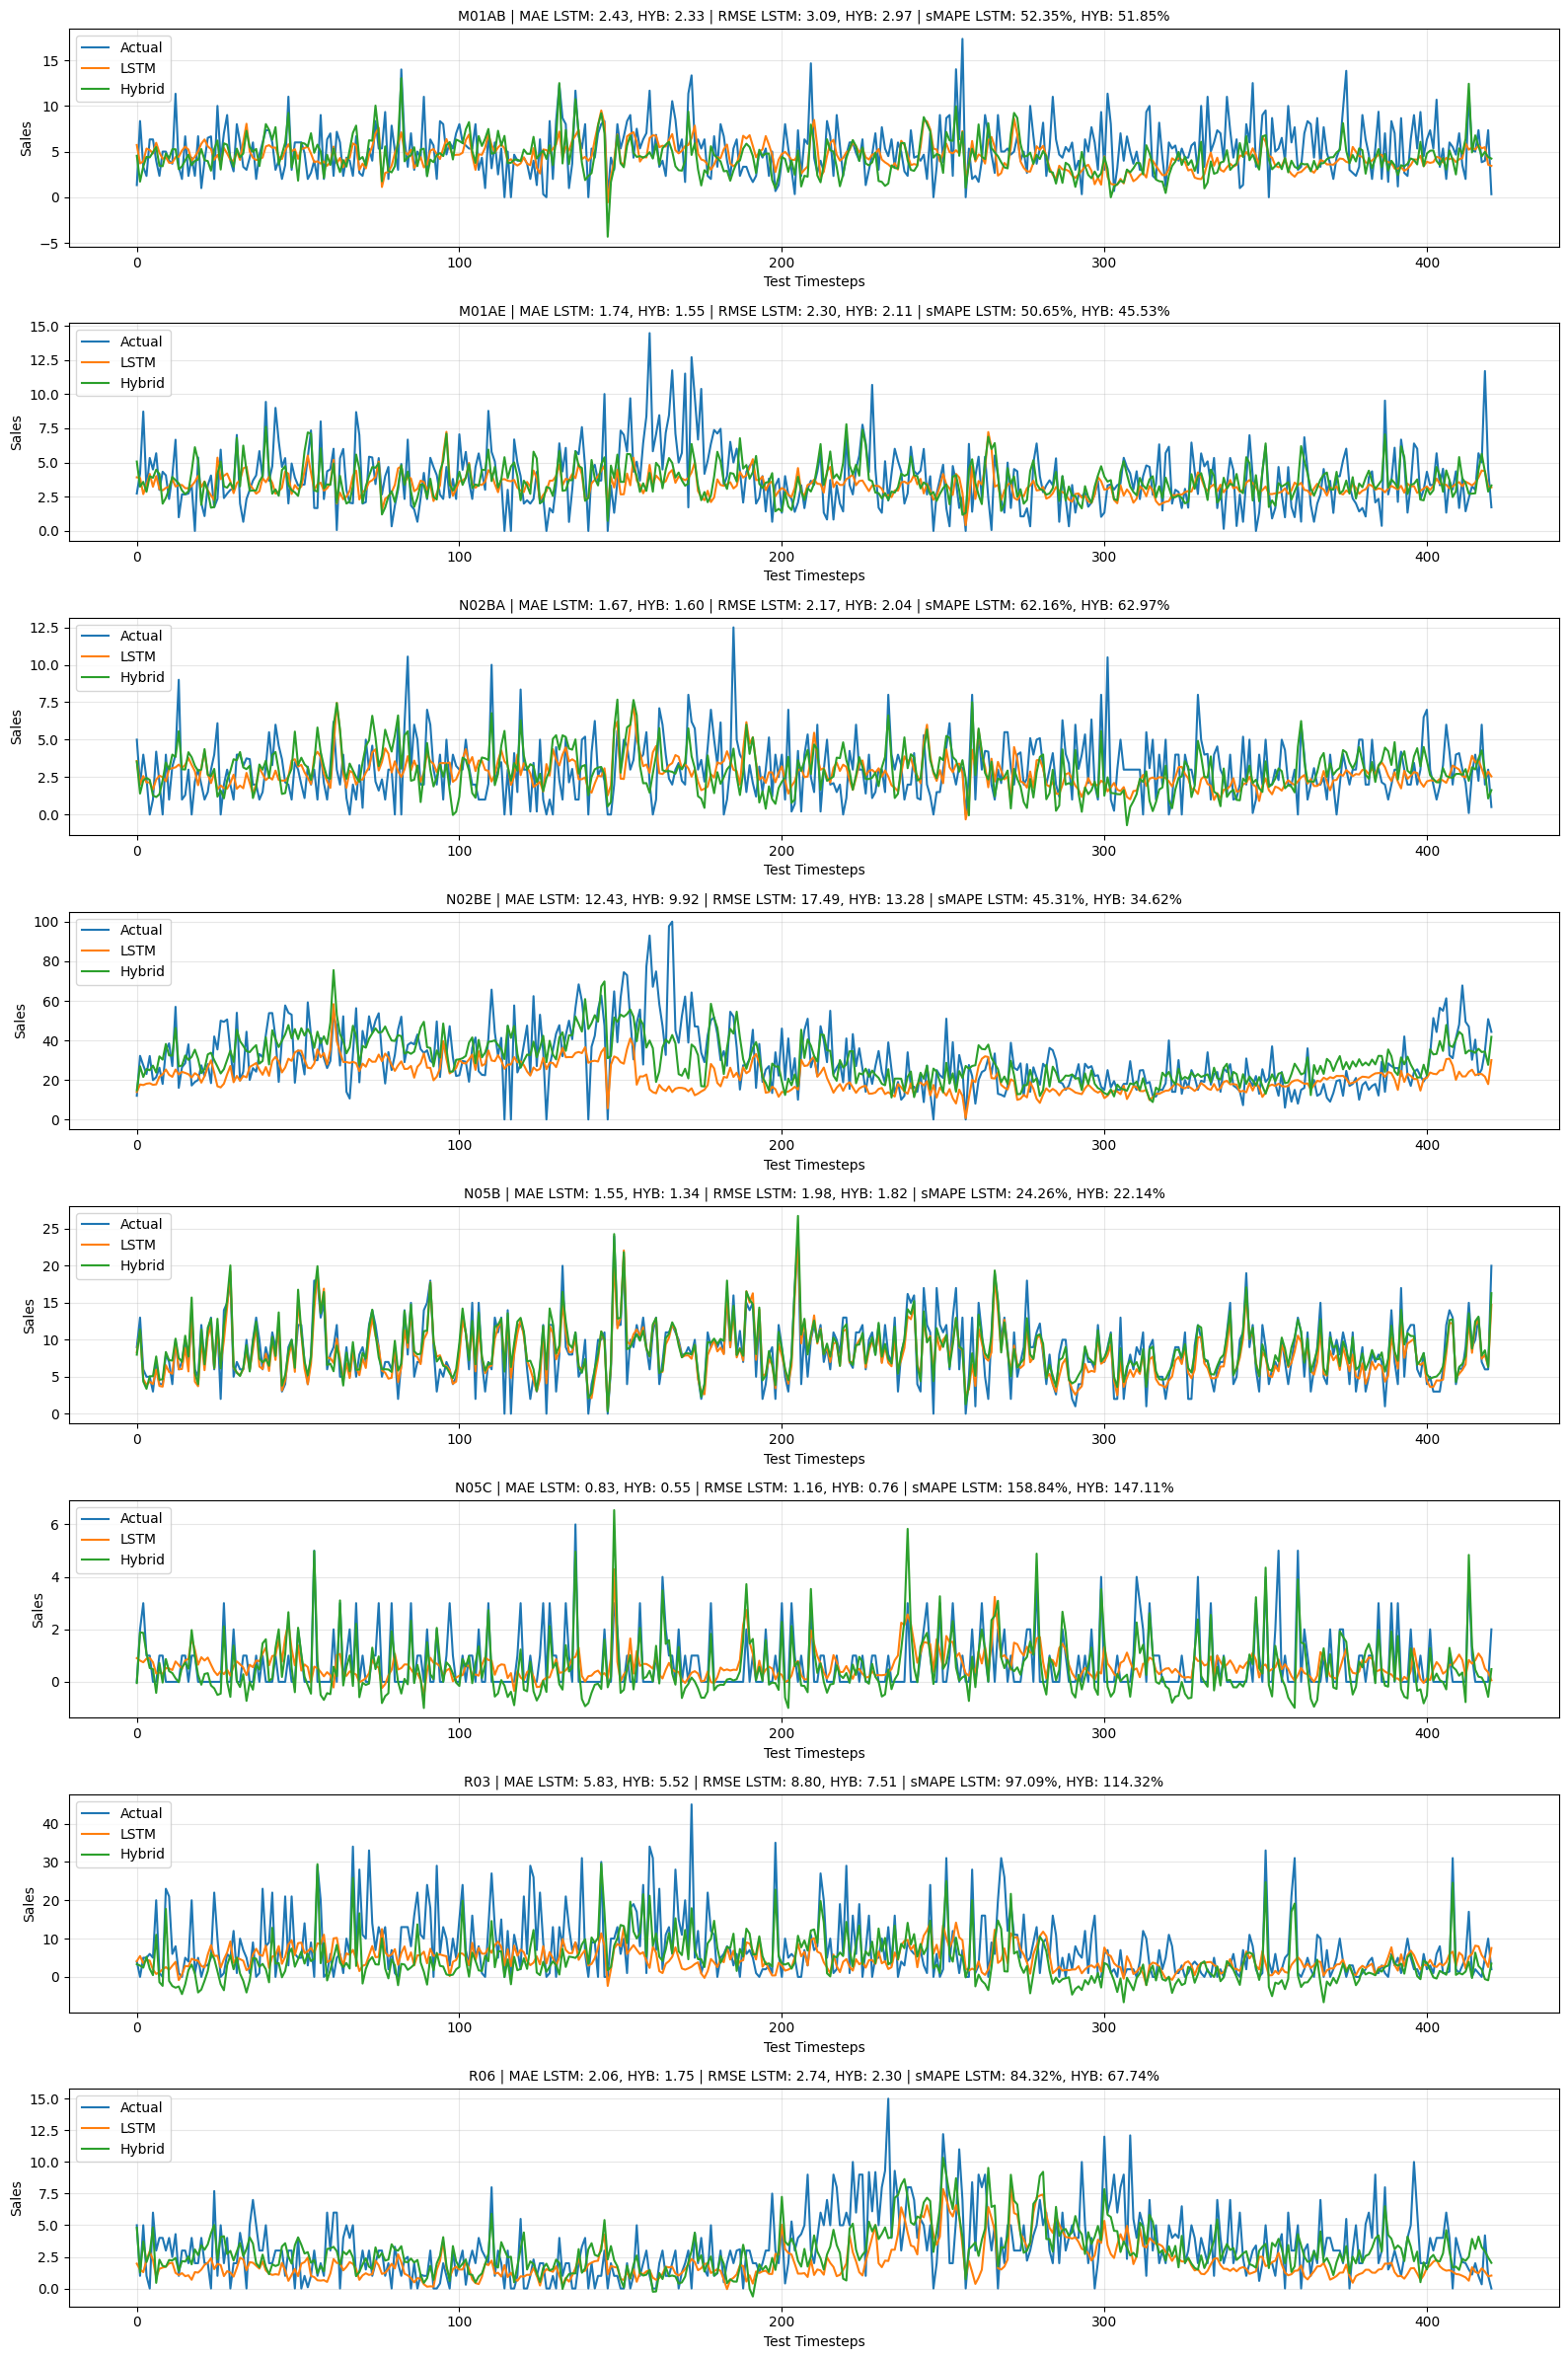

In [ ]:
# ----------- 1-step-ahead plots
plt.figure(figsize=(16, 3 * len(target_cols)))
for i, col in enumerate(target_cols, 1):
    ax = plt.subplot(len(target_cols), 1, i)
    y = Y_test[col].reset_index(drop=True)
    y_lstm = Ypred_tst_lstm[col].reset_index(drop=True)
    y_hyb = Ypred_tst_hybrid[col].reset_index(drop=True)
    ax.plot(y.values, label="Actual")
    ax.plot(y_lstm.values, label="LSTM")
    ax.plot(y_hyb.values, label="Hybrid")
    row = met_df[met_df["drug"] == col].iloc[0]
    ttl = (f"{col} | MAE LSTM: {row['MAE_LSTM']:.2f}, HYB: {row['MAE_HYBRID']:.2f} | "
           f"RMSE LSTM: {row['RMSE_LSTM']:.2f}, HYB: {row['RMSE_HYBRID']:.2f} | "
           f"sMAPE LSTM: {row['sMAPE_LSTM']:.2f}%, HYB: {row['sMAPE_HYBRID']:.2f}%")
    ax.set_title(ttl, fontsize=10)
    ax.set_xlabel("Test Timesteps")
    ax.set_ylabel("Sales")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

## Plotting Forecasts
Generates plots for 7-day and 30-day forecasts for each drug, comparing LSTM and hybrid predictions against historical data.

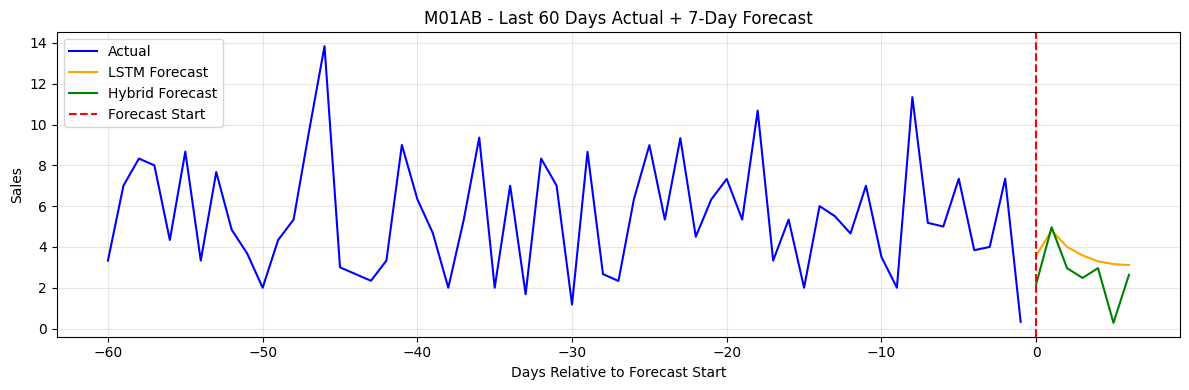

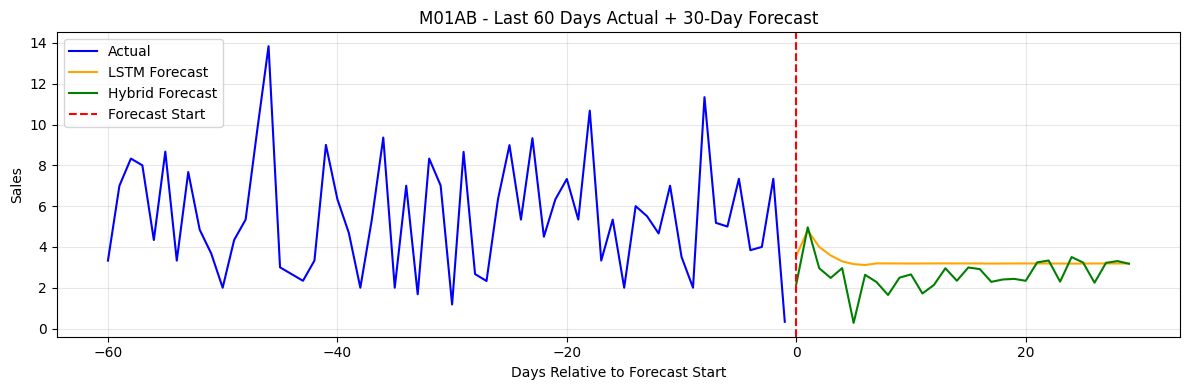

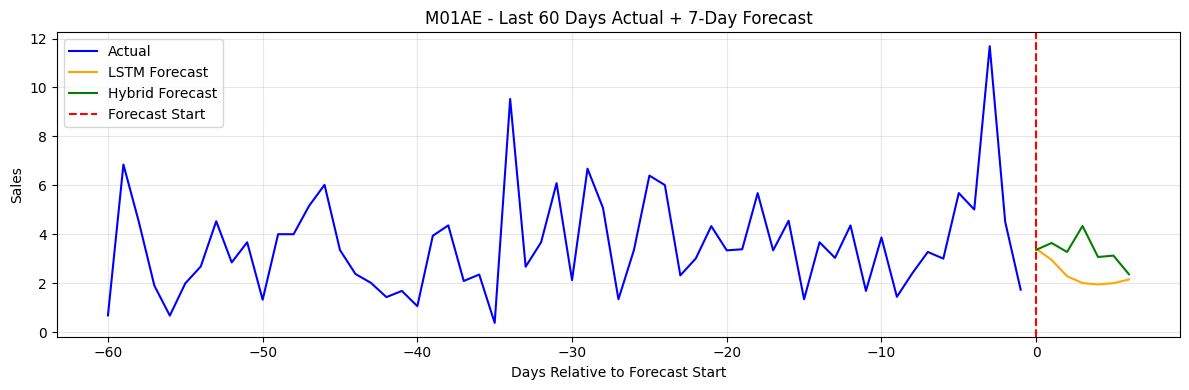

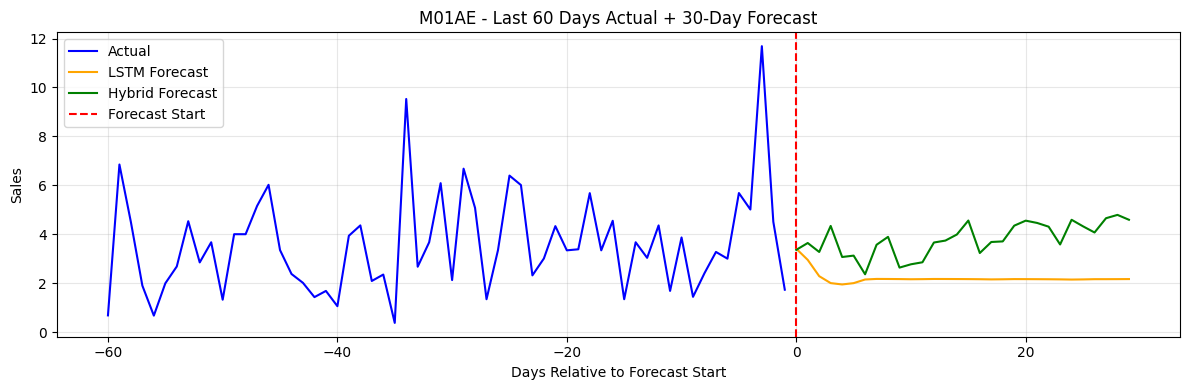

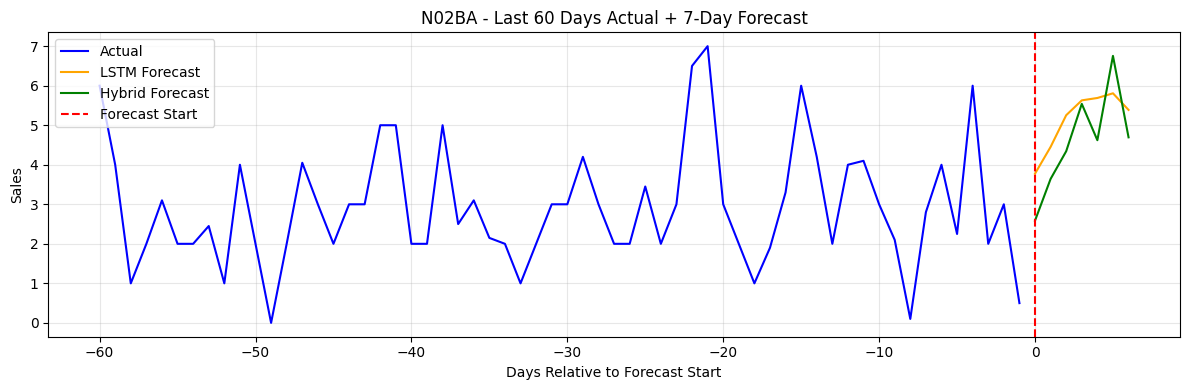

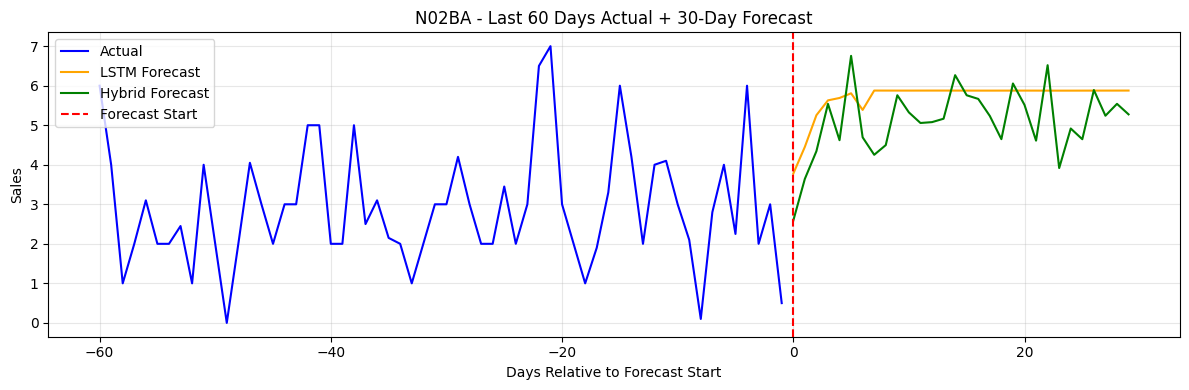

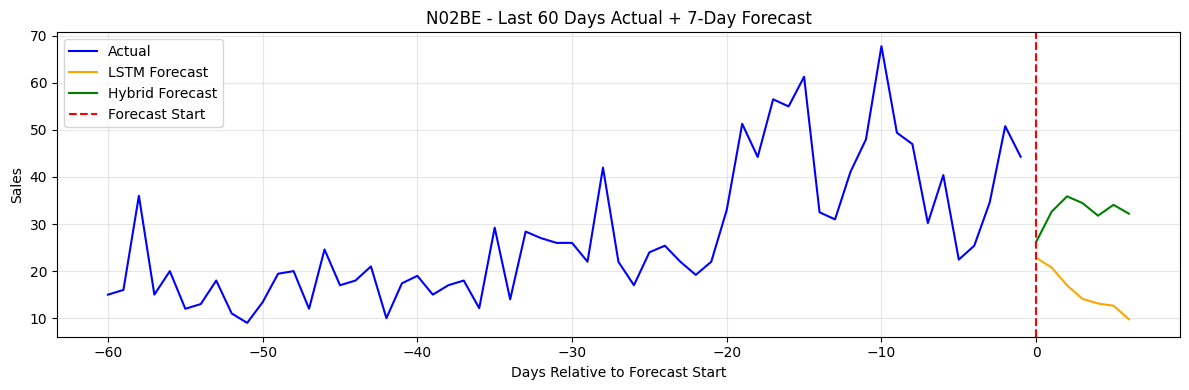

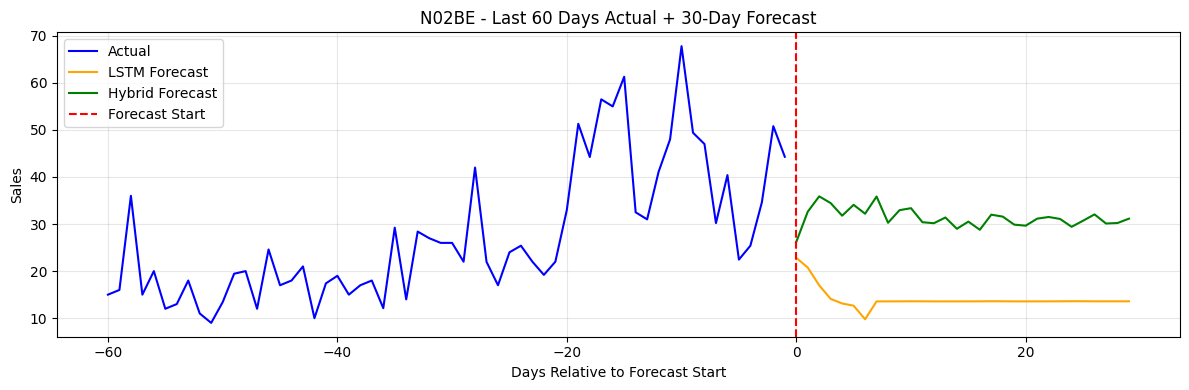

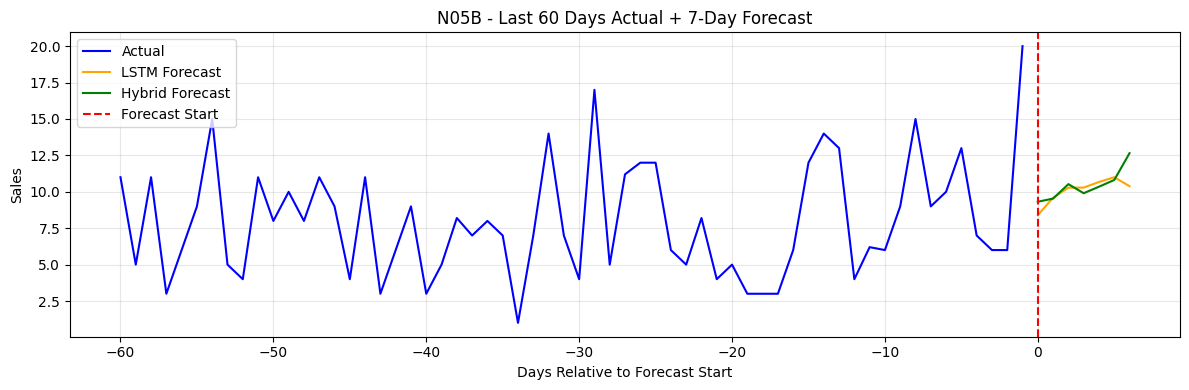

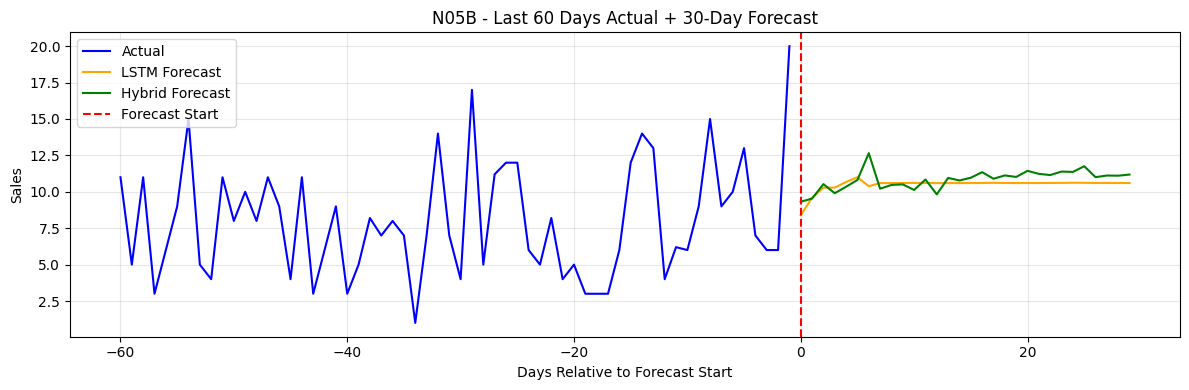

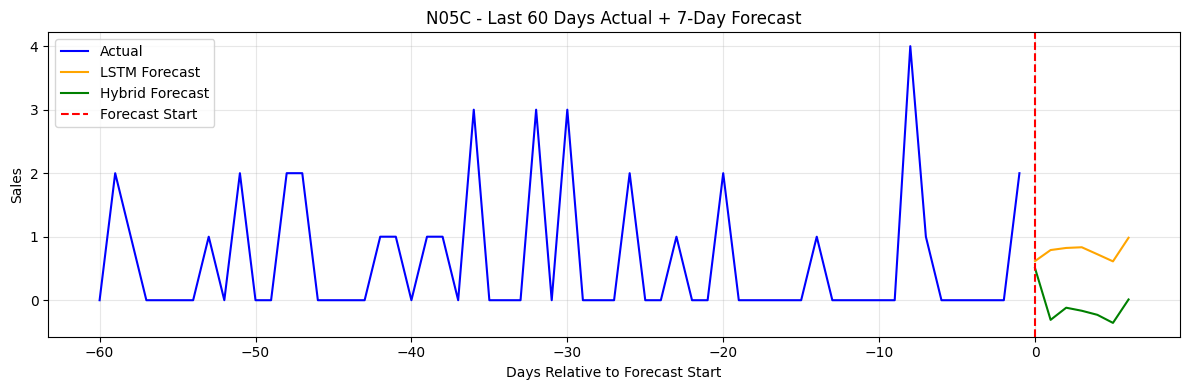

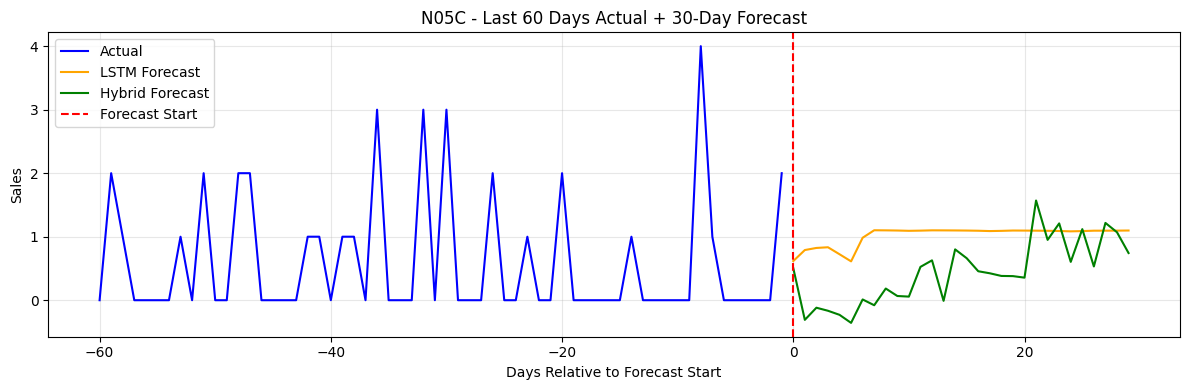

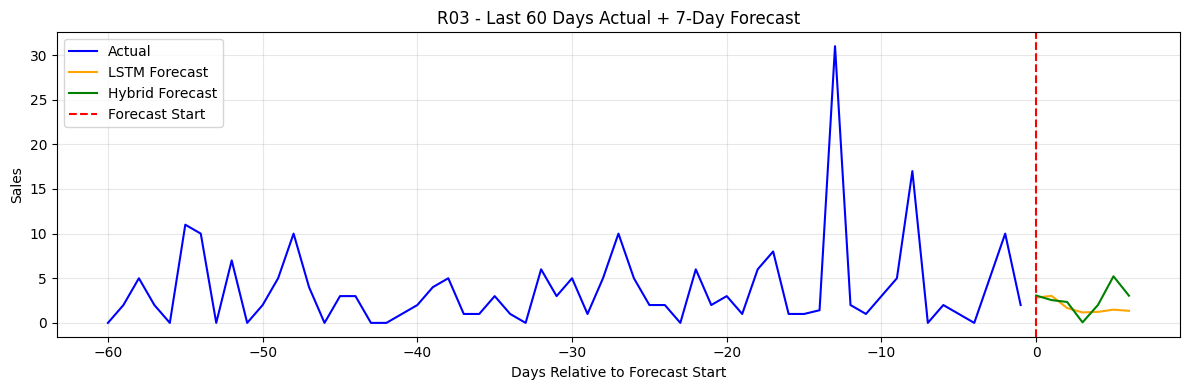

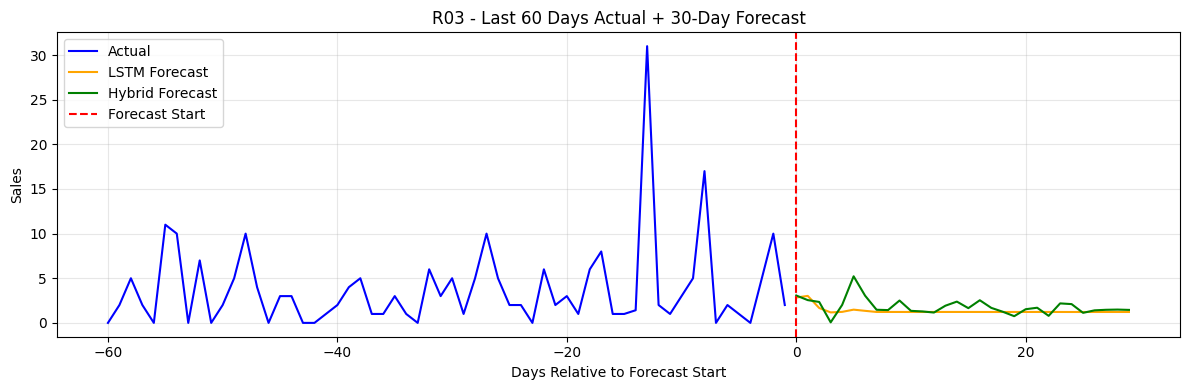

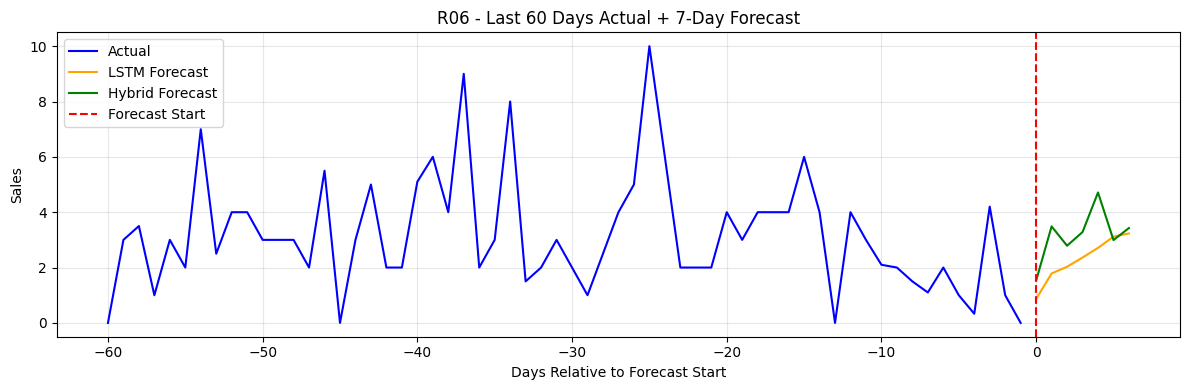

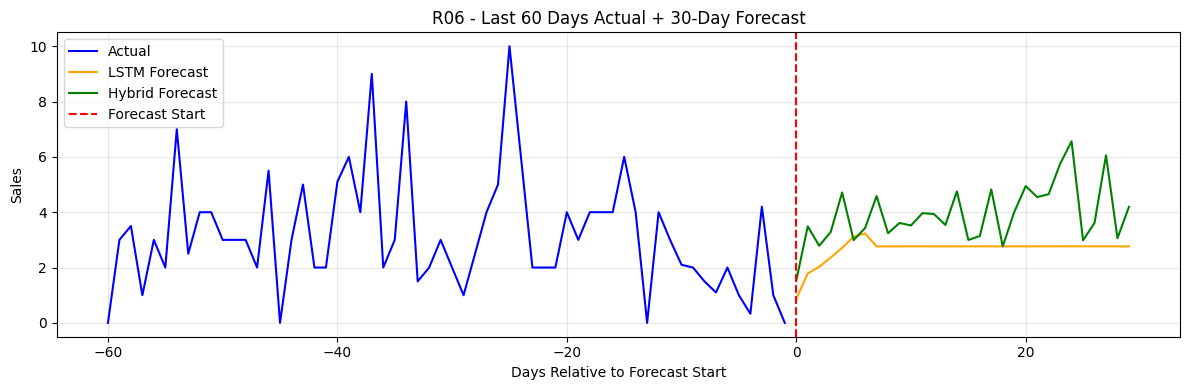

In [ ]:
# ----------- Plot for each drug (7-day and 30-day forecasts)
for col in target_cols:
    plot_forecast(col, Y_df, forecast_7_lstm, forecast_7_hybrid, horizon=7, lookback_days=60)
    plot_forecast(col, Y_df, forecast_30_lstm, forecast_30_hybrid, horizon=30, lookback_days=60)

## Conclusion
- **Inferences**:
  - The hybrid model outperforms LSTM alone, with improved MAE, RMSE, and sMAPE across most drug categories, as shown in `metrics_unified.csv`.
  - The model effectively captures temporal patterns (via LSTM) and non-linear residuals (via XGBoost), making it suitable for pharmacy sales forecasting.
  - 7-day and 30-day forecasts provide actionable insights for inventory planning, with hybrid predictions showing tighter alignment with trends.
- **Strengths**:
  - Robust handling of multiple forecast horizons.
  - Incorporates rich exogenous features (holidays, calendar).
  - Modular design allows easy tuning and extension.
- **Next Steps**: Analyze saved CSVs (`forecast_7_hybrid.csv`, `forecast_30_hybrid.csv`) for inventory decisions and refine the model based on stakeholder feedback.